In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
import statsmodels.api as sm
from scipy.stats import norm

American Option

In [2]:
(S0, K, T, vol, r, d) = (100, 100,1, 0.2, 0.03, 0)

Implicit Finite Difference Method

Implicit Method Value: 6.731324546331434


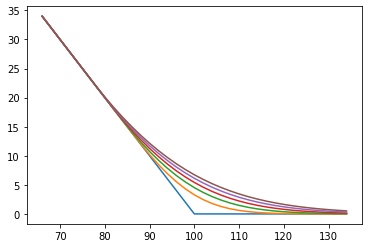

In [5]:
Smax=2*S0
N=100
dS=Smax/N

S=np.linspace(0,Smax,N+1)
n=np.arange(N+1)

J=10000
dt=T/J
Tau=np.arange(J+1)*dt

pd=-dt/2*(vol**2*n**2-(r-d)*n)
pu=-dt/2*(vol**2*n**2+(r-d)*n)
pc=1+dt*(vol**2*n**2+r)

A=diags([pc,pd[1:],pu[:-1]],[0,-1,1]).toarray()
Ainv=np.linalg.inv(A)

V = np.clip(K-S,0,1e10)
exV=V.copy()

cut = int(N/3)
tslice = int(J/5)

plt.plot(S[cut:-cut],V[cut:-cut])
for j in range(1,1+J):
    V=Ainv.dot(V)
    V=np.where(exV>V,exV,V)
    V[0]=K
    V[N]=0
    if j%tslice==0:
        plt.plot(S[cut:-cut],V[cut:-cut]);
        
print("Implicit Method Value:",V[50])

Explicit Method Value: 6.731670567814701


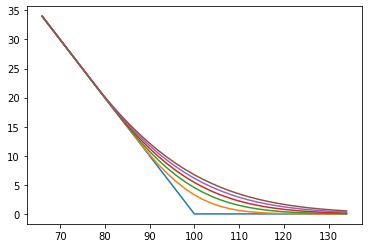

In [6]:
pd=(dt/2*(vol**2*n**2-(r-d)*n))/(1+r*dt)
pu=(dt/2*(vol**2*n**2+(r-d)*n))/(1+r*dt)
pc=(1-dt*(vol**2*n**2))/(1+r*dt)

A=diags([pc,pd[1:],pu[:-1]],[0,-1,1]).toarray()

V = np.clip(K-S,0,1e10)
exV=V.copy()

cut = int(N/3)
tslice = int(J/5)

plt.plot(S[cut:-cut],V[cut:-cut])
for j in range(1,1+J):
    V=A.dot(V)
    V=np.where(exV>V,exV,V)
    V[0]=K
    V[N]=0
    if j%tslice==0:
        plt.plot(S[cut:-cut],V[cut:-cut]);
        
print("Explicit Method Value:",V[50])

Crank-Nicolson Method

Crank-Nicolson Method Value: 6.731501434905439


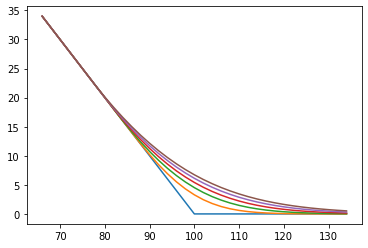

In [7]:
pcf=dt*n*n*vol*vol/2-1+dt*r/2
puf=-dt*((r-d)*n+n*n*vol*vol)/4
pdf=dt*((r-d)*n-n*n*vol*vol)/4

pc=-dt*n*n*vol*vol/2-1-dt*r/2
pu=-puf
pd=-pdf


A=diags([pcf,pdf[1:],puf[:-1]],[0,-1,1]).toarray()
B=diags([pc,pd[1:],pu[:-1]],[0,-1,1]).toarray()
Binv=np.linalg.inv(B)

V = np.clip(K-S,0,1e10)
exV=V.copy()

cut = int(N/3)
tslice = int(J/5)

plt.plot(S[cut:-cut],V[cut:-cut])
for j in range(1,1+J):
    V=Binv.dot(A.dot(V))
    V=np.where(exV>V,exV,V)
    V[0]=K
    V[N]=0
    if j%tslice==0:
        plt.plot(S[cut:-cut],V[cut:-cut]);
        
print("Crank-Nicolson Method Value:",V[50])

Longstaff-Schwartz Method

In [8]:
J=100 #num of periods
dt=T/J
Tau=np.arange(1,J+1)*dt
numpath=100000
rnd = np.random.RandomState(20)
dW=rnd.normal(0,vol*np.sqrt(dt),size=(numpath,J))
sigma=dW.cumsum(-1)
mu=(r-d-0.5*vol*vol)*Tau
St=S0*np.exp(mu+sigma)

payoff=lambda s,k : np.maximum(k-s,0)
getX=lambda x: sm.add_constant(np.array([x,x**2]).T)
fit=lambda x,y : sm.OLS(y,x).fit().predict
CF=payoff(St,K)

for i in range(J-1,0,-1):
    dfi=np.exp(-r*np.arange(1,J-i+1)*dt)
    conVal=(CF[:,i:]*dfi).max(-1)
    pCF=CF[:,i-1]
    pS=St[:,i-1]
    
    X=getX(pS[pCF>0])
    Y=conVal[pCF>0]
    fittedmodel=fit(X,Y)
    EconVal=fittedmodel(getX(pS))
    
    pCF[EconVal>=pCF]=0
    tmp=CF[:,i:]
    tmp[np.arange(numpath)[pCF!=0],:]=0
    CF[:,i:]=tmp
    CF[:,i-1]=pCF

DF=np.exp(-r*Tau)
PutValAM=np.mean((CF*DF).sum(-1))
print("Longstaff-Schwartz Method Value: ",PutValAM)

Longstaff-Schwartz Method Value:  6.744866132419887
